## Qiskit quantum neural network (QNN) tutorial
In this notebook, we implement a quantum neural network (QNN) for a data classification task. Our dataset consists of images containing horizontal and vertical stripes, and our goal is to label unseen images into one of the two categories depending on the orientation of their line. As the ansatz of our QNN, we specifically construct a [quantum convolutional neural network](https://www.nature.com/articles/s41567-019-0648-8) (QCNN). For data generation and ansatz construction, we follow the strategy found [here](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html).

### Data generation
We start by randomly generating a dataset consisting of 2x4 images with horizontal and vertical lines. Images with horizontal lines are labeled -1 and vertical with +1.

In [1]:
import numpy as np 


def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((6, 8))
    ver_array = np.zeros((4, 8))

    j = 0
    for i in range(0, 7):
        if i != 3:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1

    j = 0
    for i in range(0, 4):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 4] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, 6)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, 4)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(8):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels

We split the generated data into training and test sets.

In [2]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

We can now display some images from the dataset with horizontal or vertical lines.

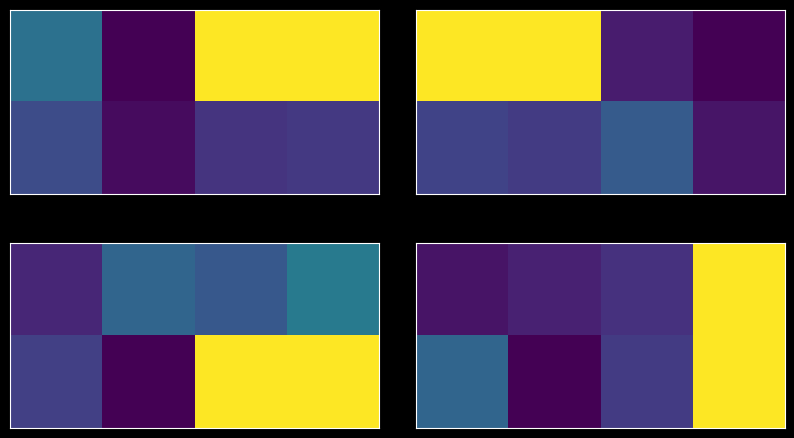

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 4),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

### Defining the neural network ansatz
As mentioned previously, our ansatz is a quantum convolutional neural network (QCNN), consisting of alternating convolutional and pooling layers. 

We start by constructing the parametric two-qubit unitary which will be the building block of the convolutional layer. As a design choice, we implement these convolutional circuits as the 3-parameter gate set found in between the CNOT gate blocks of the [KAK decomposition](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.69.032315).

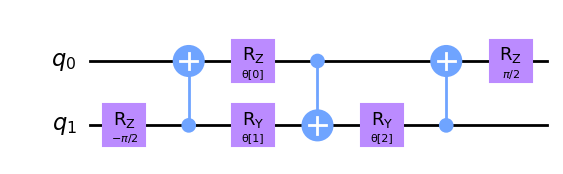

In [4]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Display the convolutional circuit
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

The convolutional layer consists of these two-qubit unitaries laid out in non-overlapping nearest-neighbor topology in 2 layers as defined below.

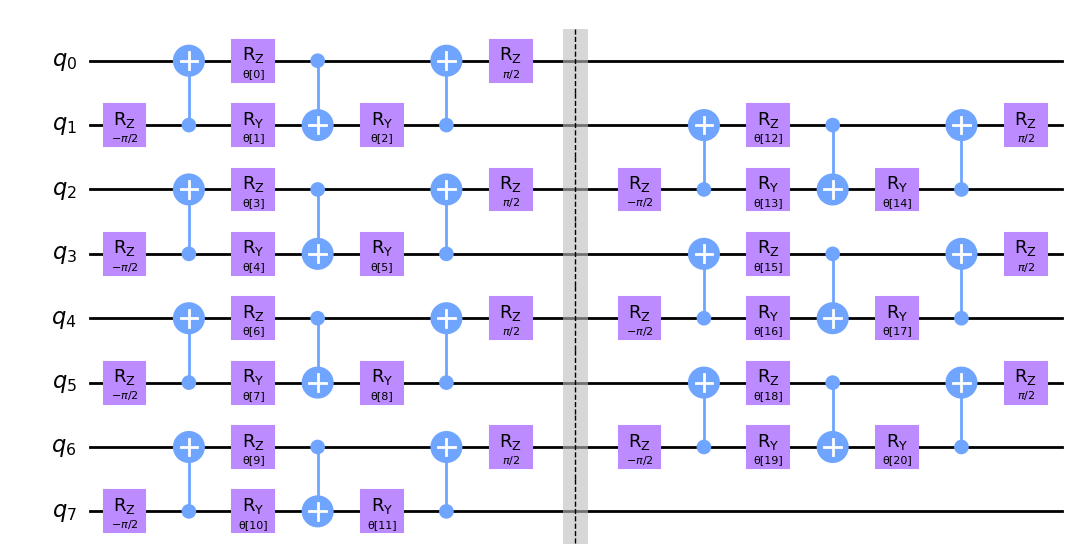

In [5]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        param_index += 3
    qc.barrier()
    for q1, q2 in zip(qubits[1::2], qubits[2::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


# Display the convolutional layer for an example of 8 qubits
circuit = conv_layer(8, "θ")
circuit.decompose().draw("mpl", style="clifford")

The pooling layer also consists of two-qubit unitaries, which we choose to design with 3 parameters as below.

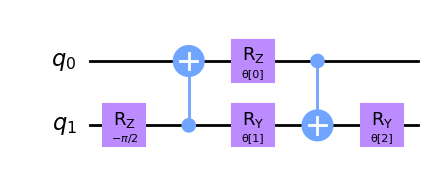

In [6]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


# Display the pooling circuit
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

When putting the pooling layer together, we connect a pair of qubits with the two-qubit unitaries defined above. Then we trace out one of the qubits per pooling circuit block, i.e. we discard half of the qubits in the entire pooling layer and effectively reduce the system size by half.

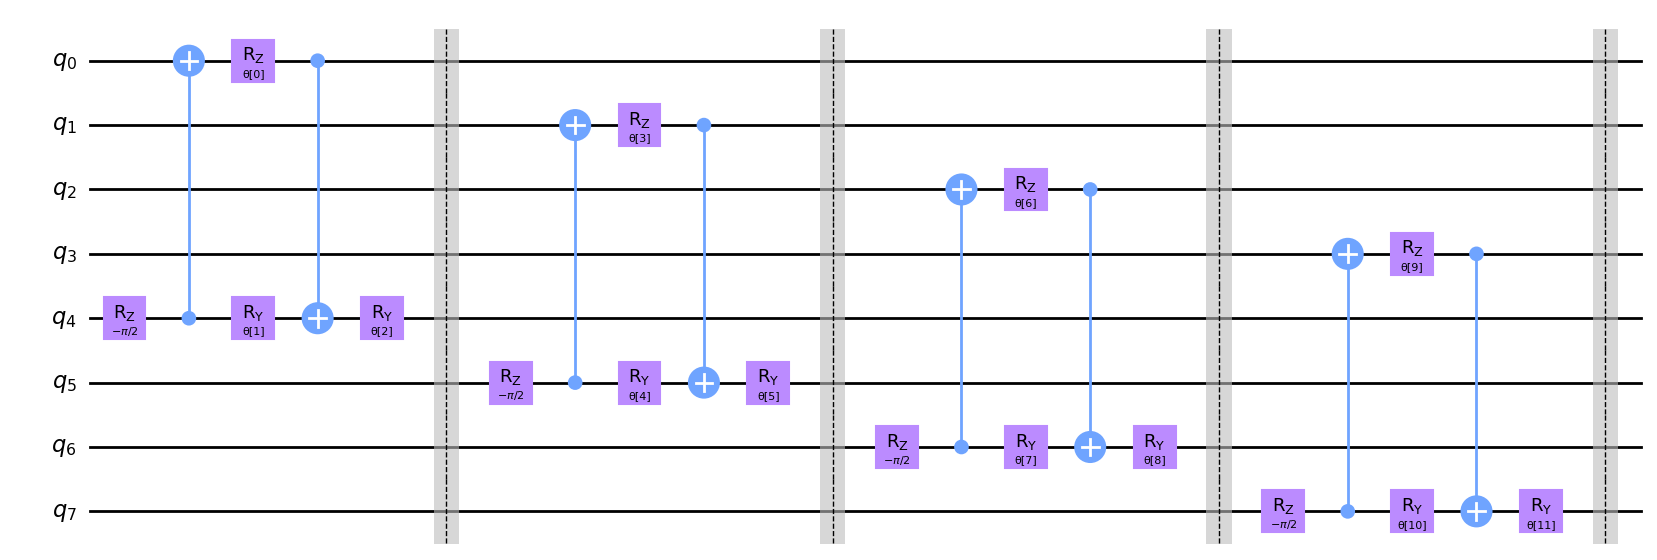

In [7]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


# Display the pooling layer with an example of 8 qubits, where source qubits are discarded afterwards
sources = [0, 1, 2, 3]
sinks = [4, 5, 6, 7]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

## Qiskit Patterns Step 1: Mapping the problem to quantum circuits
We are now ready to build the whole quantum circuit, which consists of a feature map to encode the data onto the quantum computer followed by the quantum convolutional neural network ansatz.

In [8]:
def get_qcnn_ansatz(num_qubits: int) -> QuantumCircuit:
    """
    Creates the quantum convolutional neural network (QCNN) ansatz.

    Args:
        num_qubits: number of qubits in the circuit.

    Returns:
        ansatz: QCNN ansatz as a QuantumCircuit object.
    """
    ansatz = QuantumCircuit(num_qubits, name="Ansatz")

    # Convolutional layer acts on "full_qubits" number of qubits
    # Pooling layer reduces "full_qubits" number of qubits to "half_qubits" number of qubits
    # If "full_qubits" is odd, take the larger half to ensure last pooling layer has 2->1 qubits
    full_qubits = num_qubits
    half_qubits = (num_qubits + 1) // 2

    # Add convolutional and pooling layers until there is only one qubit left for binary classification
    layer = 1
    pool_until = 1
    while full_qubits > pool_until:
        # Convolutional Layer
        ansatz.compose(conv_layer(num_qubits=full_qubits, 
                                  param_prefix=f"c{layer}"),
                       list(range(num_qubits - full_qubits, num_qubits)),
                       inplace=True)
        
        # Pooling Layer
        ansatz.compose(pool_layer(sources=list(range(0, half_qubits)),
                                  sinks=list(range(half_qubits, full_qubits)),
                                  param_prefix=f"p{layer}"),
                       list(range(num_qubits - full_qubits, num_qubits)),
                       inplace=True)

        full_qubits = half_qubits
        half_qubits = (half_qubits + 1) // 2
        layer += 1
    
    return ansatz

We encode the data onto the quantum computer using the Z Feature Map. This method uses one qubit per data feature, i.e. per pixel in this case. Then we add convolutional and pooling layers in an alternating fashion until we are left with a single qubit in the circuit. This is because we have a binary classification task and measuring a single qubit is sufficient to classify data into one of the two labels. 

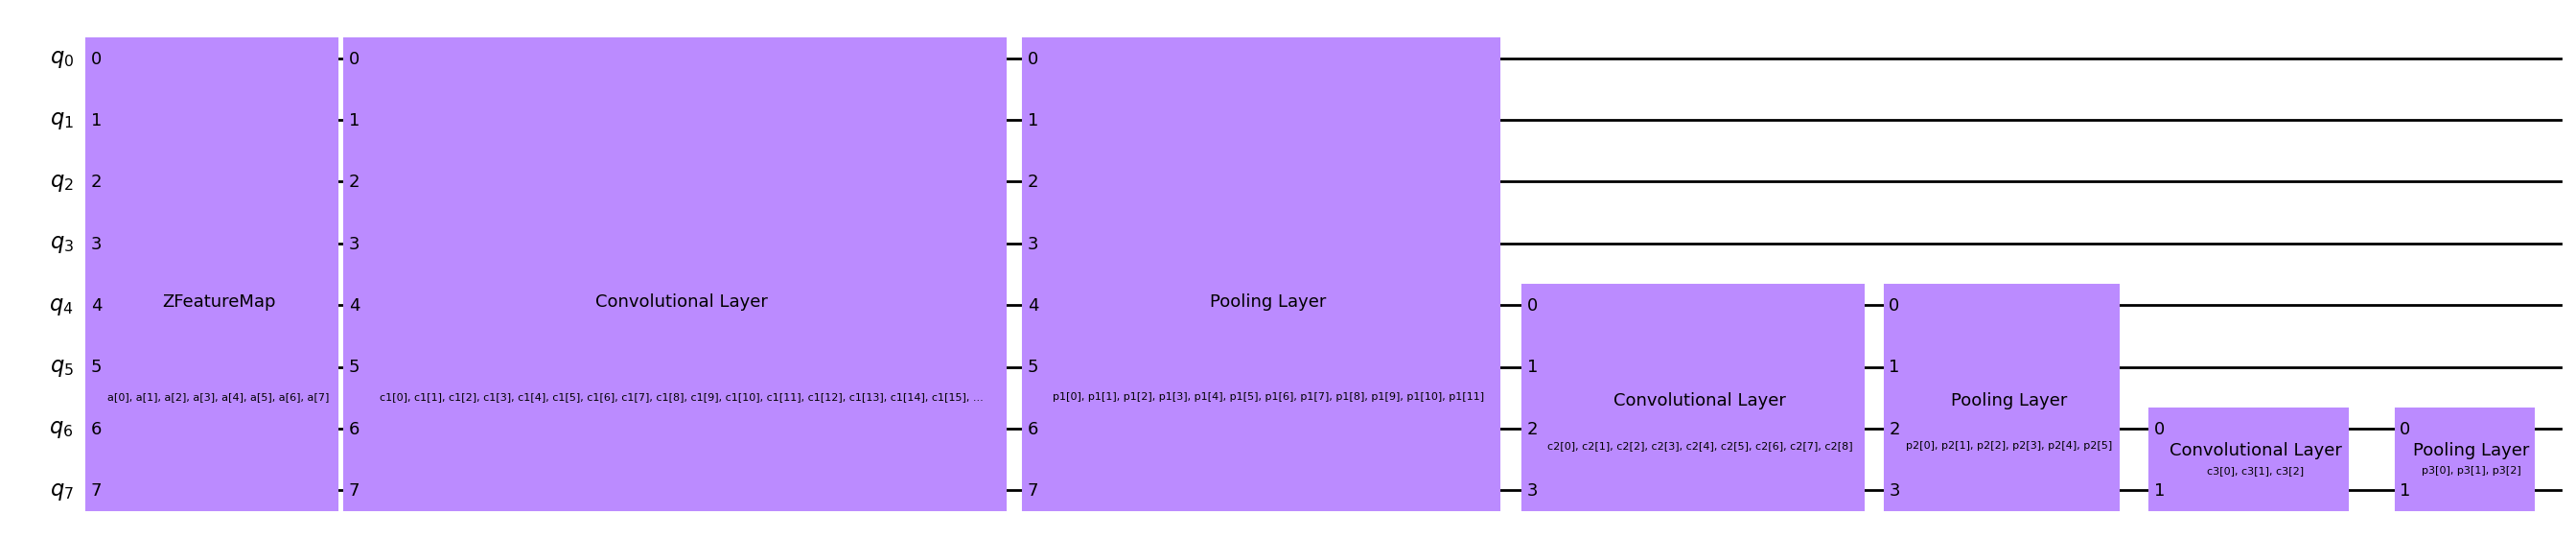

In [9]:
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp

# One qubit per data feature
num_qubits = len(train_images[0])

# Data encoding
# Note qiskit orders parameters alphabetically
feature_map = ZFeatureMap(num_qubits, parameter_prefix='a')

# QCNN ansatz
ansatz = get_qcnn_ansatz(num_qubits)

# Combine the feature map with the ansatz
circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, range(num_qubits), inplace=True)
circuit.compose(ansatz, range(num_qubits), inplace=True)

# Display the circuit
circuit.draw("mpl", style="clifford", fold=-1)

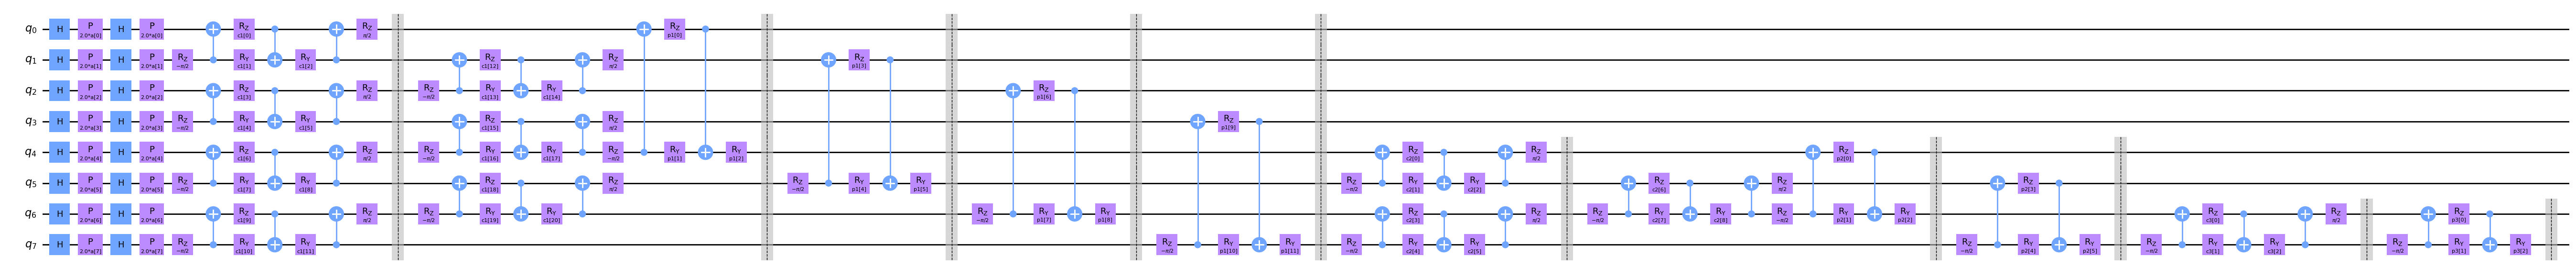

In [10]:
# Display the circuit
circuit.decompose().draw("mpl", style="clifford", fold=-1)

In [11]:
print(feature_map.parameters)
print(ansatz.parameters)
# Note that parameters are ordered alphabetically
print(circuit.parameters)

ParameterView([ParameterVectorElement(a[0]), ParameterVectorElement(a[1]), ParameterVectorElement(a[2]), ParameterVectorElement(a[3]), ParameterVectorElement(a[4]), ParameterVectorElement(a[5]), ParameterVectorElement(a[6]), ParameterVectorElement(a[7])])
ParameterView([ParameterVectorElement(c1[0]), ParameterVectorElement(c1[1]), ParameterVectorElement(c1[2]), ParameterVectorElement(c1[3]), ParameterVectorElement(c1[4]), ParameterVectorElement(c1[5]), ParameterVectorElement(c1[6]), ParameterVectorElement(c1[7]), ParameterVectorElement(c1[8]), ParameterVectorElement(c1[9]), ParameterVectorElement(c1[10]), ParameterVectorElement(c1[11]), ParameterVectorElement(c1[12]), ParameterVectorElement(c1[13]), ParameterVectorElement(c1[14]), ParameterVectorElement(c1[15]), ParameterVectorElement(c1[16]), ParameterVectorElement(c1[17]), ParameterVectorElement(c1[18]), ParameterVectorElement(c1[19]), ParameterVectorElement(c1[20]), ParameterVectorElement(c2[0]), ParameterVectorElement(c2[1]), Param

Our observable is the Pauli-Z operator on the last qubit. 

In [12]:
observable = SparsePauliOp.from_list([("Z" + "I" * (num_qubits - 1), 1)])

Before we optimize the circuit for a run on quantum hardware, we test the code on the simulator for small problem sizes. We define functions to run and train the circuit below.

### Load the data and do a forward pass
We write a function to do one forward pass of the quantum neural network. Then we test it with a small batch from the dataset and randomly initialized ansatz parameters.

In [13]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator


def forward(circuit: QuantumCircuit,
            input_params: np.ndarray, 
            weight_params: np.ndarray, 
            estimator: BaseEstimatorV2,
            observable: BaseOperator
) -> np.ndarray:
    """
    Forward pass of the neural network.
    
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive. 
        observable: a single oberservable to compute the expectation over.

    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs

    return expectation_values

Below is an example forward pass with two images from the dataset and randomly initialized ansatz parameters.

In [14]:
# from qiskit.primitives import StatevectorEstimator as Estimator  # back to EstimatorV2
from qiskit_ibm_runtime.fake_provider import FakeGuadalupe
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


backend = AerSimulator.from_backend(FakeGuadalupe())
service = QiskitRuntimeService('ibm_quantum')

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_ibm = pm.run(circuit.decompose())
observable_ibm = observable.apply_layout(circuit_ibm.layout)


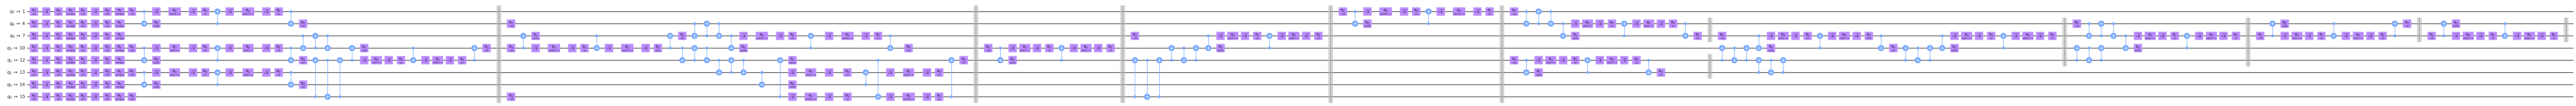

In [15]:
# Display the circuit
circuit_ibm.draw("mpl", style="clifford", fold=-1, idle_wires=False)

In [16]:
# from qiskit.primitives import StatevectorEstimator as Estimator


np.random.seed(42)

result = forward(circuit=circuit_ibm, 
                 input_params=np.array(train_images[:2]), 
                 weight_params=np.random.rand(len(ansatz.parameters)) * 2 * np.pi, 
                 estimator=Estimator(backend=backend), 
                 observable=observable_ibm)
print(result)

[0.04394531 0.12792969]


### Loss function
Now we define the loss function that will be minimized during training. For this example, we implement the mean squared error (MSE) loss function.

In [17]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError ("input should be 1d-array")

Below is an example run of the loss function.

In [18]:


batch_size = 2
train_images_batch = np.array(train_images[:batch_size])
train_labels_batch = np.array(train_labels[:batch_size])
print(f"True labels: {train_labels_batch}")

np.random.seed(42)

pred_batch = forward(circuit=circuit_ibm, 
                     input_params=train_images_batch, 
                     weight_params=np.random.rand(len(ansatz.parameters)) * 2 * np.pi,
                     estimator=Estimator(backend=backend),
                     observable=observable_ibm)
print(f"Predictions: {pred_batch}")

loss = mse_loss(predict=pred_batch, target=train_labels_batch)
print(f"Loss: {loss}")

True labels: [-1 -1]
Predictions: [0.07568359 0.14306641]
Loss: 1.2318480014801025


### Cost function
We now define the cost function that will be provided to the optimizer. This function only takes the ansatz parameters as input; other variables for the forward pass and the loss are set as global parameters.

In [19]:
def cost_function(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    predictions = forward(circuit=circuit, 
                          input_params=input_params, 
                          weight_params=weight_params, 
                          estimator=estimator, 
                          observable=observable)
    
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
    
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

We set the initial variables for the cost function.

In [20]:
# Globals
circuit = circuit_ibm
input_params = train_images_batch
estimator = Estimator(backend=backend)
observable = observable_ibm
target = train_labels_batch
objective_func_vals = []
iter = 0

Below is an example run of the cost function.

In [21]:
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
cost_function(weight_params)

Iter: 0, loss: 1.1626780033111572


1.1626780033111572

### Optimizer
Now we run the optimizer once for a small batch from the training data. We use the COBYLA method for minimization in this example.

In [37]:
from scipy.optimize import minimize

res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 3000})
print(res)

Iter: 75700, loss: 1.0481778383255005
Iter: 75750, loss: 0.7566759586334229
Iter: 75800, loss: 0.747071385383606
Iter: 75850, loss: 0.48577427864074707
Iter: 75900, loss: 0.4790806770324707
Iter: 75950, loss: 0.4851800203323364
Iter: 76000, loss: 0.4850625991821289
Iter: 76050, loss: 0.4555225372314453
Iter: 76100, loss: 0.4697304964065552
Iter: 76150, loss: 0.47005176544189453
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.4740772247314453
       x: [ 3.847e+00  6.613e+00 ...  5.783e+00  4.818e+00]
    nfev: 511
   maxcv: 0.0


In [35]:
import cma
import warnings
warnings.filterwarnings("ignore")
sigma0 = 1 # initial value for the variance for cma-es
xopt, es = cma.fmin2(cost_function, weight_params, sigma0, options={'maxiter': 300})
res = {}
res['x'] = xopt

(7_w,15)-aCMA-ES (mu_w=4.5,w_1=34%) in dimension 54 (seed=966562, Mon Jul  1 21:35:00 2024)
Iter: 2100, loss: 1.2407007217407227
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 9.552990198135376e-01 1.0e+00 9.47e-01  9e-01  9e-01 0:06.8
    2     30 9.640276432037354e-01 1.0e+00 9.10e-01  9e-01  9e-01 0:13.3
    3     45 9.838879108428955e-01 1.0e+00 8.81e-01  9e-01  9e-01 0:20.3
Iter: 2150, loss: 0.8802739381790161
    4     60 8.802739381790161e-01 1.1e+00 8.62e-01  9e-01  9e-01 0:27.1
    5     75 7.189351320266724e-01 1.1e+00 8.50e-01  8e-01  9e-01 0:34.4
    6     90 7.621856927871704e-01 1.1e+00 8.43e-01  8e-01  8e-01 0:42.2
Iter: 2200, loss: 1.1096950769424438
    7    105 8.567029237747192e-01 1.1e+00 8.41e-01  8e-01  8e-01 0:50.4
    8    120 6.718131303787231e-01 1.1e+00 8.39e-01  8e-01  8e-01 0:58.3
    9    135 7.656309604644775e-01 1.1e+00 8.30e-01  8e-01  8e-01 1:06.5
Iter: 2250, loss: 1.006269931793213
   11    165 6.821280717849731e-

In [36]:
from scipy.optimize import dual_annealing
bounds = [(0,10) for _ in range(len(weight_params))]
res = dual_annealing(cost_function, bounds=bounds, maxiter =  300)
print(res)

Iter: 6600, loss: 1.1185541152954102
Iter: 6650, loss: 1.1018037796020508
Iter: 6700, loss: 1.2258350849151611
Iter: 6750, loss: 0.8537583351135254
Iter: 6800, loss: 0.9698793888092041
Iter: 6850, loss: 1.0972900390625
Iter: 6900, loss: 1.1569267511367798
Iter: 6950, loss: 1.0839134454727173
Iter: 7000, loss: 0.8741438388824463
Iter: 7050, loss: 0.8373565673828125
Iter: 7100, loss: 0.8427603244781494
Iter: 7150, loss: 0.807381272315979
Iter: 7200, loss: 0.8316308259963989
Iter: 7250, loss: 0.8450891971588135
Iter: 7300, loss: 0.8460789918899536
Iter: 7350, loss: 0.81043541431427
Iter: 7400, loss: 0.8535866737365723
Iter: 7450, loss: 0.8327862024307251
Iter: 7500, loss: 0.8384119272232056
Iter: 7550, loss: 0.818976640701294
Iter: 7600, loss: 0.8366767168045044
Iter: 7650, loss: 0.8440266847610474
Iter: 7700, loss: 0.8358837366104126
Iter: 7750, loss: 0.8311744928359985
Iter: 7800, loss: 0.877113938331604
Iter: 7850, loss: 0.8100807666778564
Iter: 7900, loss: 0.816070556640625
Iter: 7950

In [38]:
from qiskit_algorithms.optimizers import SPSA


spsa = SPSA(maxiter=3000)
res = spsa.minimize(cost_function, x0=weight_params)
print(res)

Iter: 76200, loss: 1.1363422870635986
Iter: 76250, loss: 0.9977818727493286
Iter: 76300, loss: 0.5104094743728638
Iter: 76350, loss: 0.3455907106399536
Iter: 76400, loss: 0.3455698490142822
Iter: 76450, loss: 0.30434906482696533
Iter: 76500, loss: 0.25975239276885986
Iter: 76550, loss: 0.2614480257034302
Iter: 76600, loss: 0.24513447284698486
Iter: 76650, loss: 0.2741415500640869
Iter: 76700, loss: 0.24506211280822754
Iter: 76750, loss: 0.24595844745635986
Iter: 76800, loss: 0.25732100009918213
Iter: 76850, loss: 0.264473557472229
Iter: 76900, loss: 0.2308189868927002
Iter: 76950, loss: 0.2808037996292114
Iter: 77000, loss: 0.2493821382522583
Iter: 77050, loss: 0.2767273187637329
Iter: 77100, loss: 0.2331392765045166
Iter: 77150, loss: 0.2554361820220947
Iter: 77200, loss: 0.2798347473144531
Iter: 77250, loss: 0.23719072341918945
Iter: 77300, loss: 0.2842733860015869
Iter: 77350, loss: 0.25603532791137695
Iter: 77400, loss: 0.2690854072570801
Iter: 77450, loss: 0.22023248672485352
Iter

In [39]:
len(weight_params)

54

We run a forward pass with the learned parameters to see accuracy over the small training batch.

In [ ]:
print(f"Learned weights: {res['x']}")
pred_batch = forward(circuit, train_images_batch, res['x'], estimator, observable)
print(f"Forward pass expectations: {pred_batch}")

Since this is a classification task, we use the mean value 0 of the class labels as the cutoff value.

In [ ]:
import copy

pred_labels_batch = copy.deepcopy(pred_batch)
pred_labels_batch[pred_labels_batch >= 0] = 1
pred_labels_batch[pred_labels_batch < 0] = -1

print(f"Predicted labels: {pred_labels_batch}")
print(f"True labels: {train_labels_batch}")

## Qiskit Patterns Step 2: Optimize problem for quantum execution

We start by selecting a backend for execution.

In [ ]:
# from qiskit_ibm_runtime import QiskitRuntimeService

# service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
# backend = service.least_busy(operational=True, simulator=False)
# print(backend.name)

In [ ]:
# from qiskit_ibm_runtime.fake_provider import FakeKyiv
# from qiskit_aer import AerSimulator
# from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator


# backend = AerSimulator.from_backend(FakeKyiv())
# service = QiskitRuntimeService('ibm_quantum')

Here we optimize the circuit for running on a real backend by specifying the optimization_level and adding dynamical decoupling. The code below generates a mass manager using preset pass managers from qiskit.transpiler.

In [ ]:
# from qiskit.circuit.library import XGate
# from qiskit.transpiler import PassManager
# from qiskit.transpiler.passes import (
#     ALAPScheduleAnalysis,
#     ConstrainedReschedule,
#     PadDynamicalDecoupling,
# )
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# target = backend.target
# pm = generate_preset_pass_manager(target=target, optimization_level=3)
# pm.scheduling = PassManager(
#     [
#         ALAPScheduleAnalysis(target=target),
#         ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
#         PadDynamicalDecoupling(
#             target=target, dd_sequence=[XGate(), XGate()], pulse_alignment=target.pulse_alignment
#         ),
#     ]
# )

Now we use the pass manager on the initial state. We can similarly apply device layout characteristics to the observable to get a more physical representation.

In [ ]:
# circuit_ibm = pm.run(circuit)
# observable_ibm = observable.apply_layout(circuit_ibm.layout)

## Qiskit Patterns Step 3: Execute using Qiskit Primitives

### Loop over the dataset in batches and epochs
We first implement the full algorithm using a simulator for cursory debugging and for estimates of error. We can now go over the entire dataset in batches in desired number of epochs to train our quantum neural network.

In [ ]:
# batch_size = 35
# num_epochs = 1
# num_samples = len(train_images)

# # Globals
# circuit = circuit
# estimator = Estimator(backend=backend)  # simulator for debugging
# observables = observable
# objective_func_vals = []
# iter = 0

# # Random initial weights for the ansatz
# np.random.seed(42)
# weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

# for epoch in range(num_epochs):
#     for i in range((num_samples - 1) // batch_size + 1):
#         print(f"Epoch: {epoch}, batch: {i}")
#         start_i = i * batch_size
#         end_i = start_i + batch_size
#         train_images_batch = np.array(train_images[start_i:end_i])
#         train_labels_batch = np.array(train_labels[start_i:end_i])
#         input_params = train_images_batch
#         target = train_labels_batch
#         iter = 0
#         res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 1000})
#         weight_params = res['x']



Alternatively, we can use the SPSA optimizer.

In [ ]:
# from qiskit_algorithms.optimizers import SPSA


# spsa = SPSA(maxiter=100)

# batch_size = 35
# num_epochs = 1
# num_samples = len(train_images)

# # Globals
# circuit = circuit
# estimator = Estimator()  # simulator for debugging
# observables = observable
# objective_func_vals = []
# iter = 0

# # Random initial weights for the ansatz
# np.random.seed(42)
# weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

# for epoch in range(num_epochs):
#     for i in range((num_samples - 1) // batch_size + 1):
#         print(f"Epoch: {epoch}, batch: {i}")
#         start_i = i * batch_size
#         end_i = start_i + batch_size
#         train_images_batch = np.array(train_images[start_i:end_i])
#         train_labels_batch = np.array(train_labels[start_i:end_i])
#         input_params = train_images_batch
#         target = train_labels_batch
#         iter = 0
#         res = spsa.minimize(cost_function, x0=weight_params)
#         weight_params = res.x


We are now ready to run the training on real hardware.

In [ ]:
# # To continue running on real hardware use
# from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions, Session

# batch_size = 35
# num_epochs = 1
# num_samples = len(train_images)

# # Globals
# circuit = circuit_ibm
# observables = observable_ibm
# objective_func_vals = []
# iter = 0

# # Random initial weights for the ansatz
# np.random.seed(42)
# weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

# with Session(backend=backend):
#     session_options = EstimatorOptions()
#     session_options.default_shots = 10000
#     session_options.resilience_level = 1

#     estimator = Estimator(session=Session(service, backend=backend), options=session_options)  # hardware
    
#     for epoch in range(num_epochs):
#         for i in range((num_samples - 1) // batch_size + 1):
#             print(f"Epoch: {epoch}, batch: {i}")
#             start_i = i * batch_size
#             end_i = start_i + batch_size
#             train_images_batch = np.array(train_images[start_i:end_i])
#             train_labels_batch = np.array(train_labels[start_i:end_i])
#             input_params = train_images_batch
#             target = train_labels_batch
#             iter = 0
#             # We can replace this with other optimizers
#             res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 1500})
#             weight_params = res['x']

## Qiskit Patterns Step 4: Post-process, return result in classical format

### Testing and accuracy
We now interpret the results from training. We first test the training accuracy over the training set.

In [ ]:
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # hardware

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(train_images), res['x'], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

We now test the model accuracy over the test set.

In [ ]:
pred_test = forward(circuit, np.array(test_images), res['x'], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

Finally, we plot how the loss decreases over iterations during training.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()
